In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgbm
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from collections import Counter
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, fbeta_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_train = '/content/carvan_train.csv'
file_test = '/content/carvan_test.csv'
df_train = pd.read_csv(file_train)
df_test = pd.read_csv(file_test)

Printing the datasets for train and test and checking for nan values

In [3]:
df_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,...,0,0,0,1,0,0,0,0,0,0
5818,35,1,4,4,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
5819,33,1,3,4,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,1
5820,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_test

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85
0,33,1,4,2,8,0,6,0,3,5,...,0,0,0,0,1,0,0,0,0,0
1,6,1,3,2,2,0,5,0,4,5,...,2,0,0,0,1,0,0,0,0,0
2,39,1,3,3,9,1,4,2,3,5,...,1,0,0,0,1,0,0,0,0,0
3,9,1,2,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,31,1,2,4,7,0,2,0,7,9,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,33,1,2,4,8,0,7,2,0,5,...,0,0,0,0,1,0,0,0,0,0
3996,24,1,2,3,5,1,5,1,3,4,...,1,0,0,0,1,0,0,0,0,0
3997,36,1,2,3,8,1,5,1,3,7,...,0,0,0,0,1,0,0,0,1,0
3998,33,1,3,3,8,1,4,2,3,7,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_train.isnull().values.any()

np.False_

In [6]:
df_train.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86
count,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,...,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000,5822.000000
mean,24.253349,1.110615,2.678805,2.991240,5.773617,0.696496,4.626932,1.069907,3.258502,6.183442,...,0.005325,0.006527,0.004638,0.570079,0.000515,0.006012,0.031776,0.007901,0.014256,0.059773
std,12.846706,0.405842,0.789835,0.814589,2.856760,1.003234,1.715843,1.017503,1.597647,1.909482,...,0.072782,0.080532,0.077403,0.562058,0.022696,0.081632,0.210986,0.090463,0.119996,0.237087
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,2.000000,2.000000,3.000000,0.000000,4.000000,0.000000,2.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,1.000000,3.000000,3.000000,7.000000,0.000000,5.000000,1.000000,3.000000,6.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,35.000000,1.000000,3.000000,3.000000,8.000000,1.000000,6.000000,2.000000,4.000000,7.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,41.000000,10.000000,5.000000,6.000000,10.000000,9.000000,9.000000,5.000000,9.000000,9.000000,...,1.000000,1.000000,2.000000,7.000000,1.000000,2.000000,3.000000,2.000000,2.000000,1.000000


In [7]:
X = df_train.drop('V86', axis = 1)
y = df_train['V86']

In [8]:
y.value_counts()

,count
V86,
0,5474
1,348


Stratifying the the train data using SMOTE-TOMEK

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1, stratify = y)

In [10]:
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 2737, 1: 174})
Counter({0: 2737, 1: 174})


Resampling the imbalanced data

In [11]:
smtt = SMOTETomek(random_state = 42)

Creating lists of numerical and categorical columns

In [12]:
X_num = df_train.drop(['V1', 'V5', 'V86'], axis = 1)
X_cat = df_train[['V1','V5']]

In [13]:
num_cols = X_num.columns.values.tolist()
cat_cols = X_cat.columns.values.tolist()

In [14]:
print(num_cols)
print(cat_cols)

['V2', 'V3', 'V4', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85']
['V1', 'V5']


Creating the pipelines for preprocessing and applying model

In [15]:
num_pipe = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

In [16]:
cat_pipe = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'constant')),
    ('onehot_encoder', OneHotEncoder(handle_unknown = 'ignore'))
])

In [17]:
column_tf = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols),
],
    remainder = 'drop',
)

Performing PCA to see how many components are providing meaningful variance and shortlisting them for pipeline

In [18]:
pca1 = PCA()

In [19]:
final_pipe = Pipeline(steps = [
    ('column_transformer', column_tf), ('smote', smtt), ('PCA', pca1), ('classifier', lgbm.LGBMClassifier(device="gpu"))
])

In [20]:
final_pipe.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2733, number of negative: 2733
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 33915
[LightGBM] [Info] Number of data points in the train set: 5466, number of used features: 133
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 133 dense feature groups (0.71 MB) transferred to GPU in 0.002000 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['V2', 'V3', 'V4', 'V6', 'V7',
                                                   'V8', 'V9', 'V10', 'V11',
                                                   'V12', 'V13', 'V14', 'V15',
                                                   'V16', 'V17', 'V18', 'V19',
                                                   'V20', 'V21', 'V22', 'V23',
                                                   'V24', 'V25', 'V26', 'V27',
                                                   'V28', 'V29', 'V30', 'V31',
                                                   'V32', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['V1', 'V5'])])),
                ('smote', SMOTETomek(random_state=42)), ('PCA', PCA()),
                ('classifier', LGBMClassifier(device='gpu'))])

In [21]:
final_pipe.feature_names_in_

array(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29',
       'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38',
       'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56',
       'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65',
       'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74',
       'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83',
       'V84', 'V85'], dtype=object)

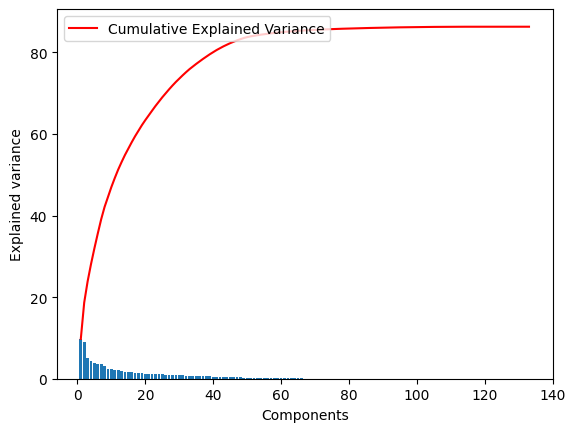

In [22]:
plt.bar(range(1,len(pca1.explained_variance_)+1),pca1.explained_variance_)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca1.explained_variance_)+1),
          np.cumsum(pca1.explained_variance_),
          c='red',
          label="Cumulative Explained Variance")
plt.legend(loc='upper left')

In [23]:
pca2 = PCA(n_components=15)

In [24]:
final_pipe = Pipeline(steps = [
    ('column_transformer', column_tf), ('smote', smtt), ('PCA', pca2), ('classifier', lgbm.LGBMClassifier(device="gpu"))
])

In [25]:
final_pipe.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2733, number of negative: 2733
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 5466, number of used features: 15
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 15 dense feature groups (0.08 MB) transferred to GPU in 0.000526 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['V2', 'V3', 'V4', 'V6', 'V7',
                                                   'V8', 'V9', 'V10', 'V11',
                                                   'V12', 'V13', 'V14', 'V15',
                                                   'V16', 'V17', 'V18', 'V19',
                                                   'V20', 'V21', 'V22', 'V23',
                                                   'V24', 'V25', 'V26', 'V27',
                                                   'V28', 'V29', 'V30', 'V31',
                                                   'V32', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['V1', 'V5'])])),
                ('smote', SMOTETomek(random_state=42)),
                ('PCA', PCA(n_components=15)),
                ('classifier', LGBMClassifier(device='gpu'))])

Tuning the model with class weights to get realistic outcomes for the given problem

In [26]:
class_weights = {0:1.33, 1:1.22}

Applying Grid Search for hyperparameter tuning

In [27]:
param_grid = {
    'classifier__learning_rate': [0.005, 0.01],
    'classifier__n_estimators': [100, 300],
    'classifier__boosting_type': ['gbdt'],
    'classifier__max_depth': [-1],
    'classifier__num_leaves': [7, 15],
    'classifier__min_child_samples': [1, 10],
    'classifier__max_bin': [63, 127],
    'classifier__bagging_fraction': [0.5, 0.9],
    'classifier__class_weight': [class_weights],
    'classifier__reg_lambda': [1, 3]
}

In [28]:
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

In [29]:
clf = GridSearchCV(final_pipe, param_grid = param_grid, cv=kfold, scoring="accuracy")

In [30]:
clf.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478431 -> initscore=-0.086328
[LightGBM] [Info] Start training from score -0.086328
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 2189, number of negative: 2189
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1905
[LightGBM] [Info] Number of data points in the train set: 4378, number of used features: 15
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry:

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['V2',
                                                                          'V3',
                                                                          'V4',
                                                                          'V6',
                                                                          'V7',
                                                                          'V8',
                                                                          'V9',
                                                                          'V10',
                                                                          'V11',
                                                                          'V12',
                                                                          'V13',
                                                                          'V14',
                                                                          'V15',
                                                                          'V16',
                                                                          'V17',
                                                                          'V18',
                                                                          'V19',
                                                                          'V20',
                                                                          'V21',
                                                                          'V22',
                                                                          'V23...
             param_grid={'classifier__bagging_fraction': [0.5, 0.9],
                         'classifier__boosting_type': ['gbdt'],
                         'classifier__class_weight': [{0: 1.33, 1: 1.22}],
                         'classifier__learning_rate': [0.005, 0.01],
                         'classifier__max_bin': [63, 127],
                         'classifier__max_depth': [-1],
                         'classifier__min_child_samples': [1, 10],
                         'classifier__n_estimators': [100, 300],
                         'classifier__num_leaves': [7, 15],
                         'classifier__reg_lambda': [1, 3]},
             scoring='accuracy')

In [31]:
clf.best_params_

{'classifier__bagging_fraction': 0.5,
 'classifier__boosting_type': 'gbdt',
 'classifier__class_weight': {0: 1.33, 1: 1.22},
 'classifier__learning_rate': 0.01,
 'classifier__max_bin': 63,
 'classifier__max_depth': -1,
 'classifier__min_child_samples': 1,
 'classifier__n_estimators': 300,
 'classifier__num_leaves': 15,
 'classifier__reg_lambda': 1}

In [32]:
train_score=clf.best_estimator_.predict_proba(X_train)
train_score

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


array([[0.65860326, 0.34139674],
       [0.67013545, 0.32986455],
       [0.88332096, 0.11667904],
       ...,
       [0.69124738, 0.30875262],
       [0.85118248, 0.14881752],
       [0.5683676 , 0.4316324 ]])

In [33]:
y_pred = clf.best_estimator_.predict(X_test)
y_pred

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


array([0, 1, 0, ..., 0, 0, 0])

In [34]:
y_true = y_test
y_true

,V86
1219,0
3260,0
1472,0
1966,0
3638,0
...,...
2427,0
2741,0
1993,0
3415,0


In [35]:
p = precision_score(y_true, y_pred)
r = recall_score(y_true, y_pred)
f = fbeta_score(y_true, y_pred, beta = 2)
print('Respective Precision, Recall and Fbeta scores are: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))

Respective Precision, Recall and Fbeta scores are: p=0.128, r=0.506, f=0.318


In [36]:
pd.Series(y_pred).value_counts()

,count
0,2224
1,687


In [37]:
cutoffs=np.linspace(0.001,0.999,999)

In [38]:
fbetas=[]

In [39]:
for cutoff in cutoffs:
  predicted=(train_score>cutoff)[:,1].astype(int)
  fbetas.append(fbeta_score(y_train, predicted, beta=2))

In [40]:
fbetas

[0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24119767119489882,
 0.24126455906821964,
 0.24126455906821964,
 0.24126455906821964,
 0.24153248195446975,
 0.24159955567897806,
 0.24193548387096775,
 0.24200278164116829,
 0.2422048

Applying Grid Search Best Estimator parameters to final pipeline

In [42]:
final_pipe = Pipeline(steps = [
    ('column_transformer', column_tf), ('smote', smtt), ('PCA', pca2), ('classifier', lgbm.LGBMClassifier(device="gpu", boosting_type = 'gbdt', learning_rate = 0.01, n_estimators= 300, max_bin = 63, max_depth = -1, bagging_fraction = 0.5, min_child_samples = 1, num_leaves = 15, class_weight = class_weights, classifier__reg_lambda = 1))
])

In [43]:
final_pipe.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 2733, number of negative: 2733
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 5466, number of used features: 15
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 15 dense feature groups (0.08 MB) transferred to GPU in 0.000474 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478431 -> in

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['V2', 'V3', 'V4', 'V6', 'V7',
                                                   'V8', 'V9', 'V10', 'V11',
                                                   'V12', 'V13', 'V14', 'V15',
                                                   'V16', 'V17', 'V18', 'V19',
                                                   'V20', 'V21', 'V22', 'V23',
                                                   'V24', 'V25', 'V26', 'V27',
                                                   'V28', 'V29', 'V30', 'V31',
                                                   'V32', ...]),
                                                 ('cat',
                                                  Pipeline(step...
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['V1', 'V5'])])),
                ('smote', SMOTETomek(random_state=42)),
                ('PCA', PCA(n_components=15)),
                ('classifier',
                 LGBMClassifier(bagging_fraction=0.5,
                                class_weight={0: 1.33, 1: 1.22},
                                classifier__reg_lambda=1, device='gpu',
                                learning_rate=0.01, max_bin=63,
                                min_child_samples=1, n_estimators=300,
                                num_leaves=15))])

In [44]:
predictions = final_pipe.predict(df_test)
predictions

[LightGBM] [Warning] Unknown parameter: classifier__reg_lambda
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


array([0, 1, 0, ..., 1, 0, 1])

In [45]:
predictions.shape

(4000,)

In [46]:
pd.Series(predictions).value_counts()

,count
0,3146
1,854


In [47]:
submissions = pd.DataFrame({'V86':predictions})

In [49]:
submissions.to_csv('proj_submission.csv',index=False)